In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.set_printoptions(suppress=True)

%reload_ext autoreload
%autoreload 2

### Weinreb Dynamic 0301_170419

#### Load the data

In [2]:
import os 
os.chdir('/ssd/users/mingzegao/clonaltrans/clonaltrans/')

path = '../trails/checkpoints/WeinrebDynamicRates/0301_112802/model_last.pt'
model = torch.load(path, map_location='cpu')
device = torch.device('cpu')

import os 
os.chdir('/ssd/users/mingzegao/clonaltrans/')

In [3]:
model_list = []

for name in tqdm(os.listdir("./trails/checkpoints/WeinrebDynamicBoots/0301_170419/models")):
    model_list.append(torch.load(f'./trails/checkpoints/WeinrebDynamicBoots/0301_170419/models/{name}', map_location='cpu'))

  3%|▎         | 23/700 [00:00<00:03, 218.25it/s]

100%|██████████| 700/700 [00:03<00:00, 208.45it/s]


#### Test loss and correlation of trails

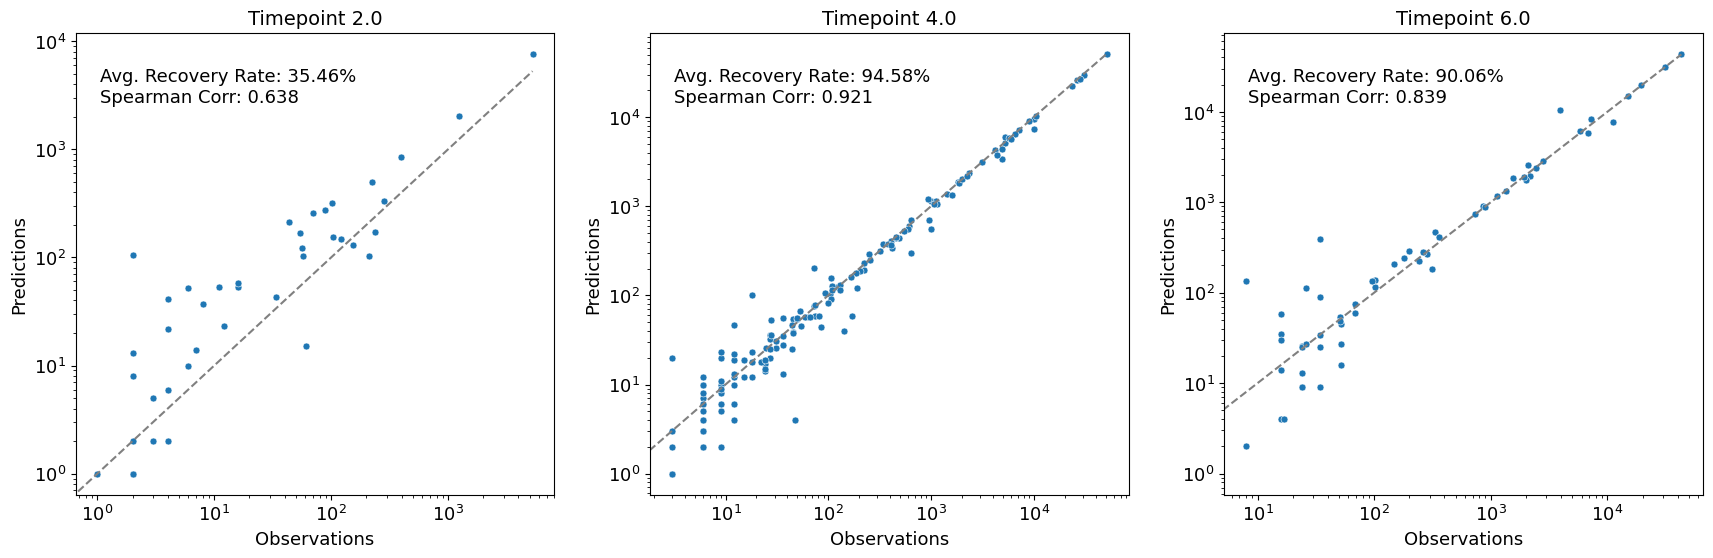

In [4]:
from clonaltrans.pl import mse_corr
test = model_list[5]
mse_corr(test, save=False)

#### Test streamlines of trails (1 min)

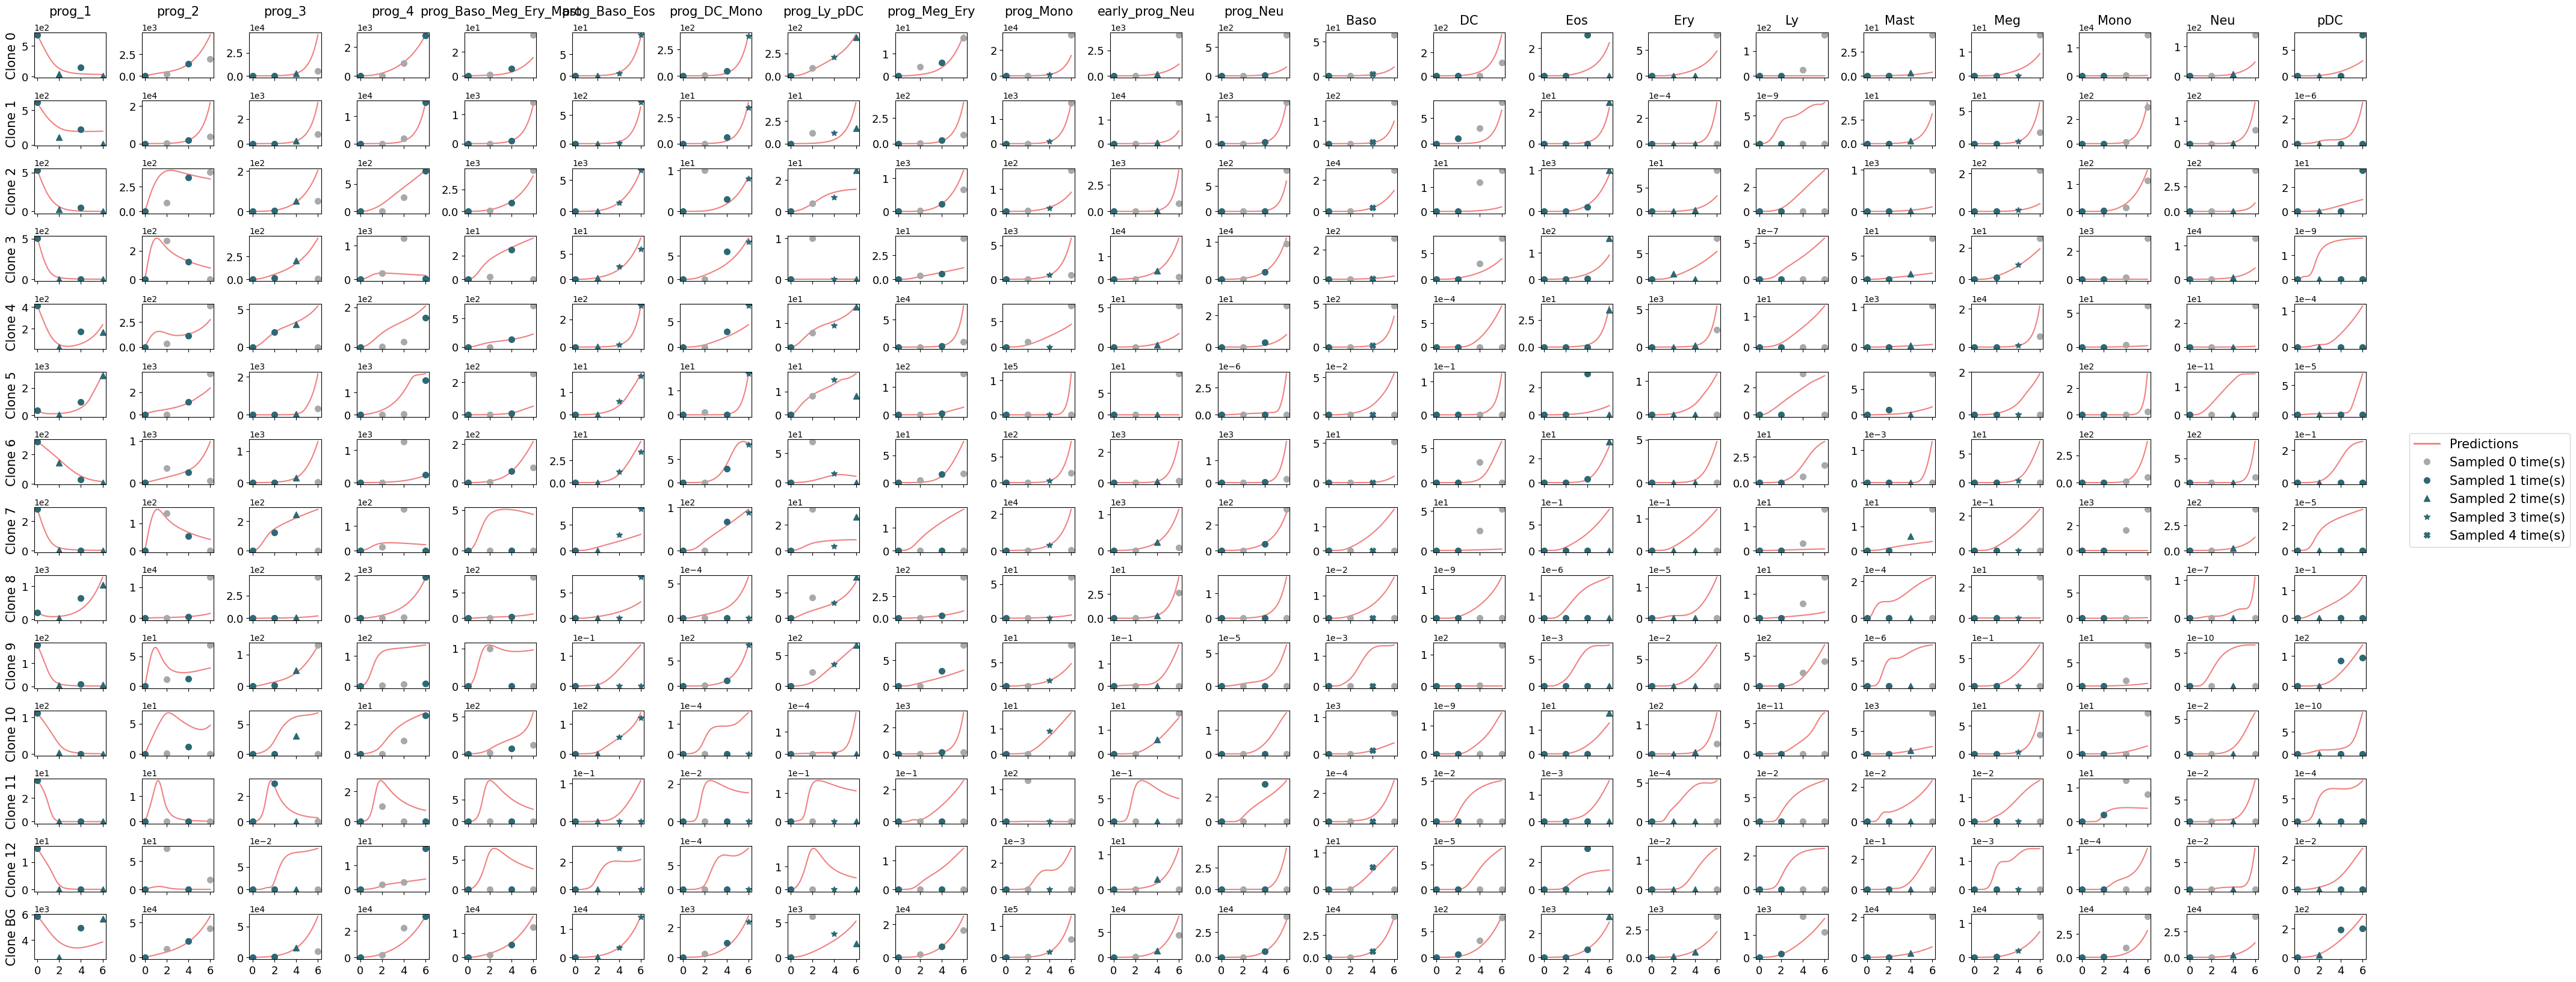

In [5]:
from clonaltrans.pl import grid_visualize
test = model_list[5]
grid_visualize(test)

#### Get 95% CI of transition rates 

One need to specify the clone index, outbound population index `pop_1`, inbound population index `pop_2` (and time points for `dynamic` mode). 

/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


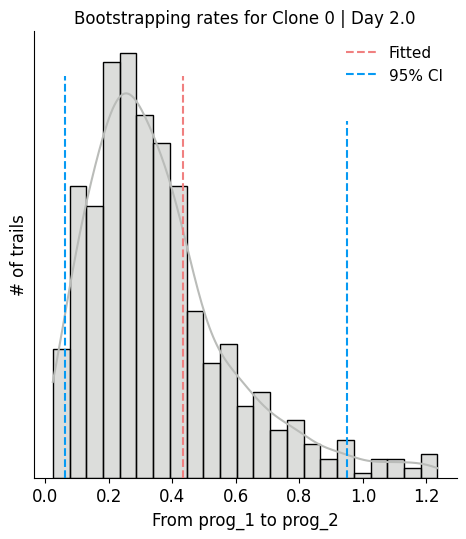

In [26]:
from clonaltrans.pl import parameter_ci
parameter_ci(
    model_list, 
    model, 
    index_clone=0, 
    pop_1=0, 
    pop_2=1, 
    tpoint=2.0
)

#### Get 25% - 75% estimation errors

705it [00:59, 11.76it/s]


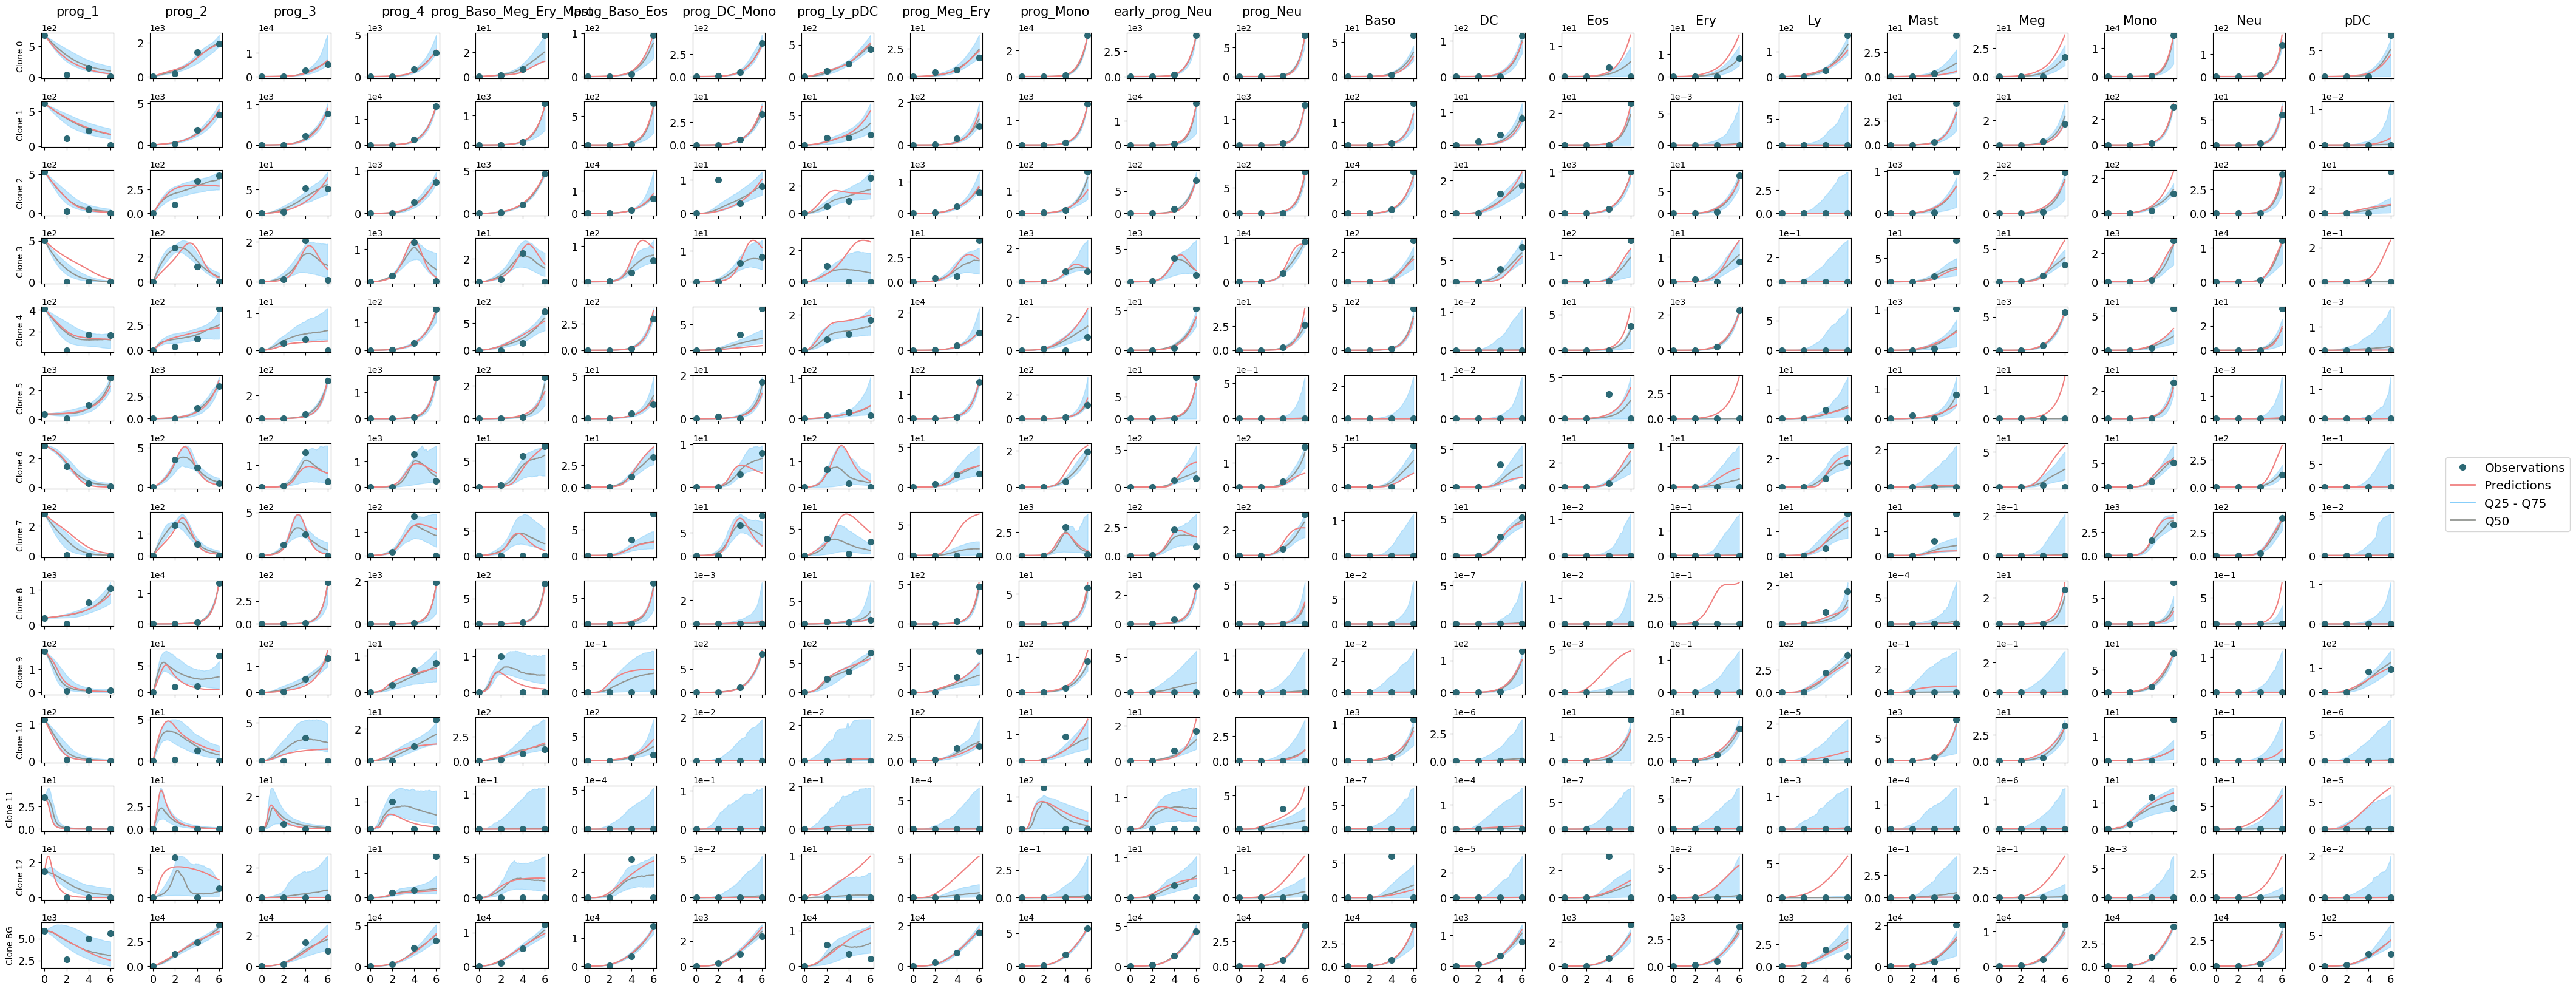

In [20]:
from clonaltrans.pl import trajectory_ci
trajectory_ci(model_list, model, 'cpu')

#### Hypothesis testing for transition rates among clones

Based on the results of bootstrapping models, we could do hypothesis testing on those transition rates and see the difference among meta-clones. Again, you need to specify time points for `dynamic` mode.

Generally, for 2 distributions, Shapiro-Wilk test is used first to detect normality.\
If passed, then do the `student independent T test`.\
If not, then do the `Mann Whitney U rank test`.

The output is a heatmap of $-log_{10}(pvalues)$. Blank means stricly non-significant.

In [28]:
from clonaltrans.utils import get_boots_K_total
tpoint = torch.tensor([4.0]).to('cpu')
K_type = model.config['arch']['args']['K_type']
total_K, ref_K = get_boots_K_total(model_list, model, K_type, tpoint)

/ssd/users/mingzegao/.conda/envs/clonetrans/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


In [29]:
from clonaltrans.utils import clone_rates_diff_test
p_values, adjusted_p_values = clone_rates_diff_test(model, total_K, correct_method='fdr_bh')
print (p_values.shape, adjusted_p_values.shape)

(91, 22, 22) (44, 91)


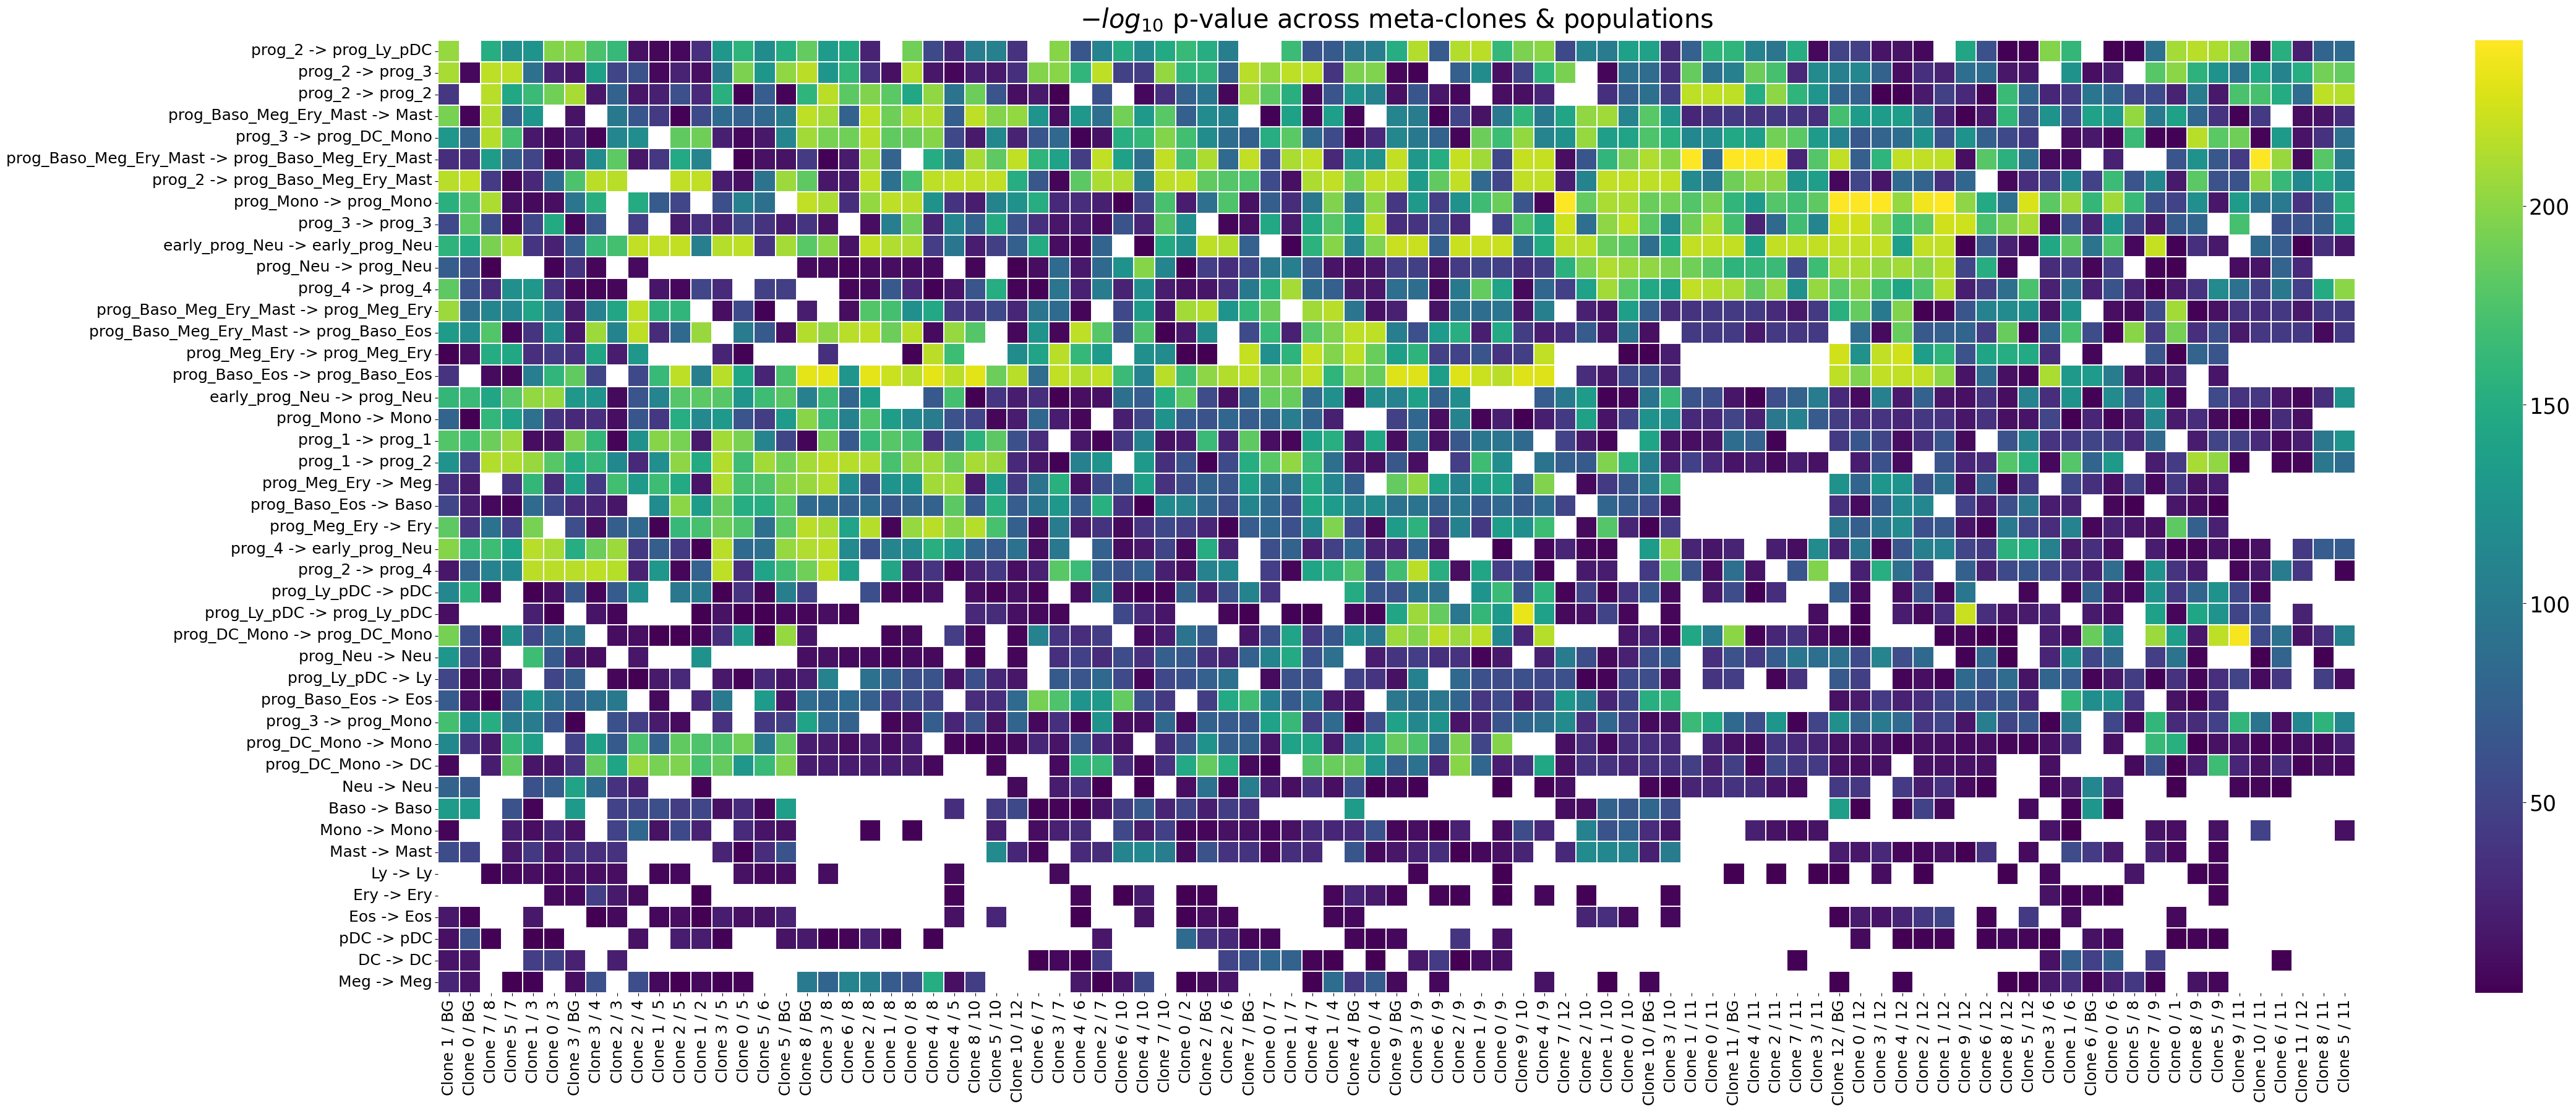

In [43]:
from clonaltrans.pl import clone_rates_diff_plot
clone_rates_diff_plot(adjusted_p_values, model)